### Семантический поиск

Задача - сделать поиск по смыслу в сметном деле.

В сметном деле сметы составляются по объемам работ.

объем работ, пример:

1)Раскопка траншеи глубиной 15 м3

2)Засыпка траншеи 15 м3

3)Прокладка кабеля - 200 м.

…

Процесс составления смет - это подбор расценки из сметнйо базы к позиции по ведомости объема работ.

Сметная база представляет собой шифр расценки +описание. Пример:

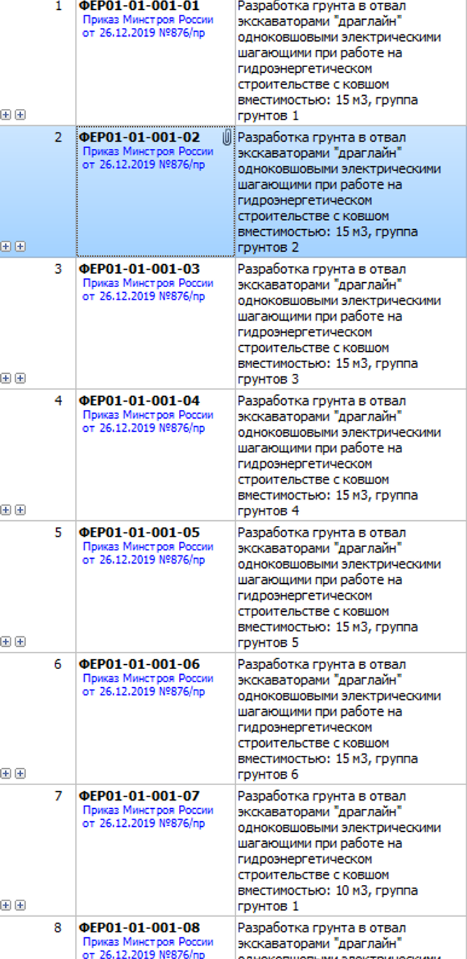

Проблема в том что поиск по сметной базе работает буквально,(не могу писать синонимы, нужно знать как в базе "песок" или "песка" иначе работу нужную не найдешь) то есть нужно помнить как в самой базе звучит расценка. Также результаты подаются подряд а не списком наиболее подходящих(пример на скрине ниже)
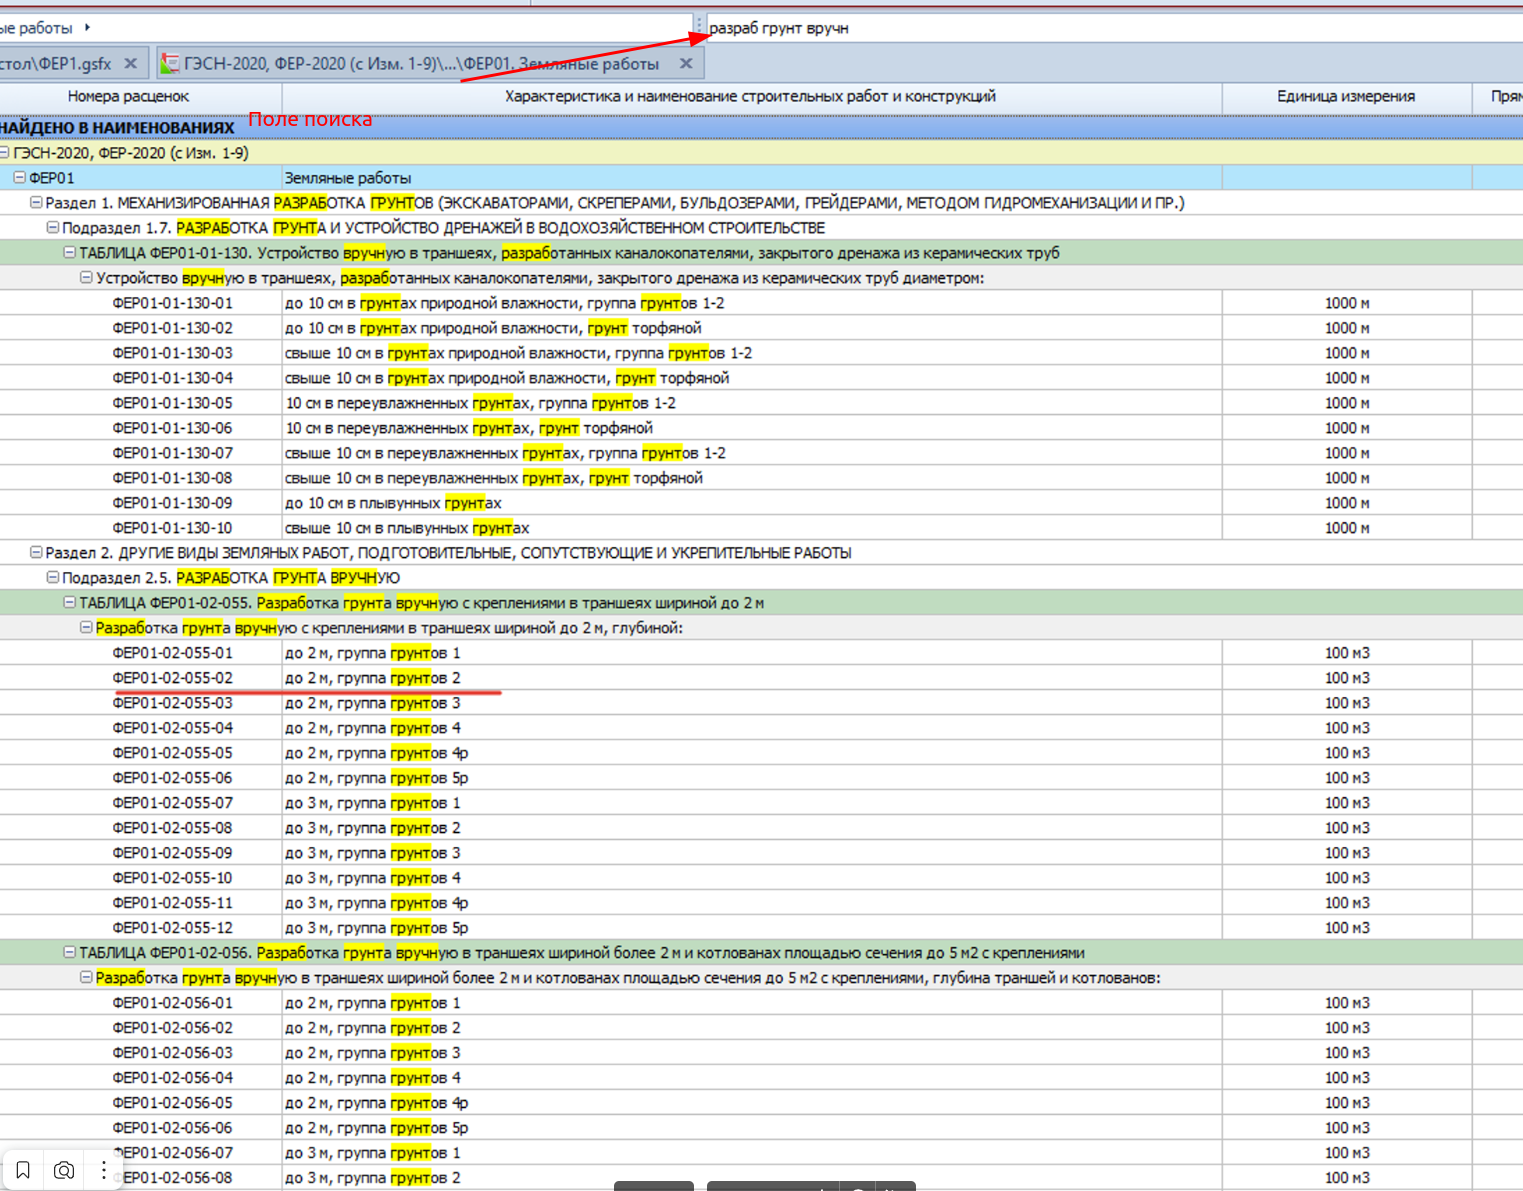
поэтому я перевел сметную базу в эмбеддинги model="text-embedding-ada-002” и попытался найти наиболее подходящие расценки из базы по ближайшему по cosine similarity

Но такой поиск иногда выдает что то странное. Конкретные примеры хорошего и плохого ниже

In [26]:
import pandas as pd
import ast
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
df = pd.read_csv('fer01_with_embeddings.csv')

In [23]:
pd.set_option('display.max_colwidth', 100)
df.sample(3)

,№,name,code,embedding
2294,2448,"Устройство каналов, дамб обвалования одноковшовыми экскаваторами с ковшом вместимостью: 0,65 (0,...",ФЕР01-01-093-15,"[-0.00584636302664876, -0.006694487761706114, -0.011518407613039017, -0.04264090210199356, -0.02..."
31,32,"Разработка грунта в отвал экскаваторами ""драглайн"" или ""обратная лопата"" с ковшом вместимостью: ...",ФЕР01-01-002-08,"[-0.01274830847978592, 0.00023189245257526636, -0.004769887309521437, -0.04264840483665466, -0.0..."
906,961,Устройство каналов и отсыпка дамб прицепными скреперами с ковшом вместимостью 8 м3 при перемещен...,ФЕР01-01-105-42,"[-0.01779714599251747, -0.0034848263021558523, -0.007386352866888046, -0.03761058300733566, -0.0..."


In [24]:
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

openai.api_key = openai_api_key
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, model="text-embedding-ada-002") -> list[float]:
    return openai.Embedding.create(input=[text], model=model)["data"][0]["embedding"]


In [30]:

df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [31]:


def get_closest_neighbors(query, df, model="text-embedding-ada-002"):
    # Convert the query into an embedding using your get_embedding function
    query_embedding = get_embedding(query, model)

    # Reshape the query embedding to match the shape of the embeddings in the df
    query_embedding = np.array(query_embedding).reshape(1, -1)

    # Calculate the cosine similarity between the query embedding and all the other embeddings
    df['similarity'] = df['embedding'].apply(lambda x: cosine_similarity([x], query_embedding)[0][0])

    # Sort the DataFrame by the similarity score and take the top 10
    df = df.sort_values('similarity', ascending=False).head(10)

    return df[['name', 'code']]


In [28]:
pd.set_option('display.max_colwidth', None)

Странный результат, "Корчевка пней". По идее мы не должны рассматривать радиус чего либо если это не труба.

In [32]:
get_closest_neighbors(query='Прокладка труб 350', df=df, model="text-embedding-ada-002")



,name,code
1291,"Укладка трубопроводов из стальных толстостенных труб при электросварном соединении, диаметр труб: 250 мм",ФЕР01-01-151-03
1294,"Укладка трубопроводов из стальных толстостенных труб при электросварном соединении, диаметр труб: 500 мм",ФЕР01-01-151-06
1858,Корчевка вручную пней диаметром: от 310 до 350 мм,ФЕР01-02-111-05
1292,"Укладка трубопроводов из стальных толстостенных труб при электросварном соединении, диаметр труб: 300 мм",ФЕР01-01-151-04
1300,"Укладка трубопроводов из стальных тонкостенных труб при электросварном соединении, диаметр труб: 300 мм",ФЕР01-01-152-01
1302,"Укладка трубопроводов из стальных тонкостенных труб при электросварном соединении, диаметр труб: 500 мм",ФЕР01-01-152-03
1309,Укладка трубопроводов из стальных толстостенных труб (соединение труб фланцевое) диаметром: 250 мм,ФЕР01-01-153-03
1312,Укладка трубопроводов из стальных толстостенных труб (соединение труб фланцевое) диаметром: 500 мм,ФЕР01-01-153-06
1320,Укладка трубопроводов из стальных толстостенных труб (соединение стыков раструбное) диаметром: 500 мм,ФЕР01-01-155-02
1296,"Укладка трубопроводов из стальных толстостенных труб при электросварном соединении, диаметр труб: 700 мм",ФЕР01-01-151-08


Ниже хорошая выдача, поисковик понял что лопатами это вручную. Но последний  1  "результат Удаление растительно-корневого покрова и торфа: в канавах торфоприемников" вообще ни к чему

In [33]:
get_closest_neighbors(query='Копание ям лопатами', df=df, model="text-embedding-ada-002")



,name,code
1553,"Копание ям вручную без креплений для стоек и столбов: с откосами глубиной до 1,5 м, группа грунтов 4",ФЕР01-02-058-08
1552,"Копание ям вручную без креплений для стоек и столбов: с откосами глубиной до 1,5 м, группа грунтов 3",ФЕР01-02-058-07
1549,"Копание ям вручную без креплений для стоек и столбов: без откосов глубиной до 0,7 м, группа грунтов 4",ФЕР01-02-058-04
1548,"Копание ям вручную без креплений для стоек и столбов: без откосов глубиной до 0,7 м, группа грунтов 3",ФЕР01-02-058-03
1551,"Копание ям вручную без креплений для стоек и столбов: с откосами глубиной до 1,5 м, группа грунтов 2",ФЕР01-02-058-06
1550,"Копание ям вручную без креплений для стоек и столбов: с откосами глубиной до 1,5 м, группа грунтов 1",ФЕР01-02-058-05
1547,"Копание ям вручную без креплений для стоек и столбов: без откосов глубиной до 0,7 м, группа грунтов 2",ФЕР01-02-058-02
1546,"Копание ям вручную без креплений для стоек и столбов: без откосов глубиной до 0,7 м, группа грунтов 1",ФЕР01-02-058-01
1512,"Укрепление нагорных и водоотводных канав, кюветов: лотками-желобами",ФЕР01-02-048-01
1415,Удаление растительно-корневого покрова и торфа: в канавах торфоприемников,ФЕР01-02-017-04


Ниже неправильный результат, первые 5 выдач "вручную" а не техникой(будьдозерами, эскаваторами и чем либо еще.) Водоотлив из траншей вообще не та операция, работа водоотлив пообще не должа в выдачу попадать

In [34]:
get_closest_neighbors(query='Засыпка траншей техникой', df=df, model="text-embedding-ada-002")



,name,code
1472,Засыпка пазух котлованов спецсооружений дренирующим песком,ФЕР01-02-033-01
1568,"Засыпка вручную траншей, пазух котлованов и ям, группа грунтов: 1",ФЕР01-02-061-01
1570,"Засыпка вручную траншей, пазух котлованов и ям, группа грунтов: 3",ФЕР01-02-061-03
1569,"Засыпка вручную траншей, пазух котлованов и ям, группа грунтов: 2",ФЕР01-02-061-02
1571,"Засыпка вручную траншей, пазух котлованов и ям, группа грунтов: 4",ФЕР01-02-061-04
770,"Засыпка траншей на полках бульдозерами грунтом из кавальеров при продольных уклонах от 6 до 15 градусов, группа грунтов: 1-3",ФЕР01-01-083-01
771,"Засыпка траншей на полках бульдозерами грунтом из кавальеров при продольных уклонах от 6 до 15 градусов, группа грунтов: 4-6",ФЕР01-01-083-02
1603,Водоотлив: из траншей,ФЕР01-02-068-01
495,Засыпка траншей и котлованов предварительно разрыхленным скальным грунтом с перемещением до 10 м бульдозерами мощностью: 79 кВт (108 л.с.),ФЕР01-01-037-01
1659,"Засыпка траншей и котлованов с рыхлением грунта: отбойными молотками, группа грунтов 3м",ФЕР01-02-077-03


Ниже хорошая выдача, у меня сразу много вариантов выдачи, причем задал синоним

In [35]:
get_closest_neighbors(query='Откачка воды', df=df, model="text-embedding-ada-002")


,name,code
1604,Водоотлив: из котлованов,ФЕР01-02-068-02
1378,Полив водой уплотняемого грунта насыпей,ФЕР01-02-006-01
1484,Полив посевов трав водой,ФЕР01-02-041-01
1603,Водоотлив: из траншей,ФЕР01-02-068-01
1381,Полив водой основания под полы промышленных цехов,ФЕР01-02-008-01
1472,Засыпка пазух котлованов спецсооружений дренирующим песком,ФЕР01-02-033-01
1216,Устройство кротового дренажа,ФЕР01-01-136-01
1514,Устройство оголовков при: лотках-желобах,ФЕР01-02-049-01
1512,"Укрепление нагорных и водоотводных канав, кюветов: лотками-желобами",ФЕР01-02-048-01
1416,Устройство прорези на болотах,ФЕР01-02-018-01


Вопрос - вомзожно ли как то "направлять" эмбеддинги, корректировать?